In [1]:
# See http://www.wikimedecine.fr/Electrocardiogramme_(ECG)_-_%C3%A9l%C3%A9ments_d%27interpr%C3%A9tation

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime, time
from funs import *

import wfdb

In [142]:
from dsfaker.generators import *
from queue import Queue


# Pan Tompkins real-time QRS detector
#   Steps: ECG -> Filters -> Derivation -> Squaring function -> Integration -> Adjusting thresholds -> Decision -> Result

class Capture(Generator):
    def __init__(self, generator):
        self.history = []
        self.gen = generator
    
    def get_single(self):
        tmp = self.gen.get_single()
        self.history.append(tmp)
        return tmp
    
    def get_batch(self, batch_size):
        tmp = self.gen.get_batch(batch_size)
        for v in tmp:
            self.history.append(v)
        return tmp
    
    def get_history(self):
        return self.history
        

class CircularBuffer(Generator):
    def __init__(self, size, initial_values=None):
        self.size = size
        if initial_values is None:
            self.buff = numpy.zeros(size, dtype=numpy.float64)
        else:
            assert size == len(initial_values)
            self.buff = numpy.asarray(initial_values)
        self.idx = 0
    
    def put(self, value):
        if self.idx == self.size:
            self.idx = 0
        self.buff[self.idx] = value
        self.idx += 1
    
    def get_prev(self, i):
        return self.buff[(self.size + self.idx + i) % self.size]
    
    def get_single(self, new_val):
        self.put(new_val)
        return new_val
    
    def get_batch(self, batch_size, new_vals):
        for e in new_vals:
            self.put(e)
        return vals
    
    def get_mean(self):
        return numpy.sum(self.buff) / self.size

class LowPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 12)
        self.old2 = 0
        self.old1 = 0
        self.delay = 6 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn6 = self.x.get_prev(-6)
        xn12 = self.x.get_prev(-12)
        xn = self.x.get_single()
        res = 2 * self.old1 - self.old2 + xn - 2 * xn6 + xn12
        self.old2 = self.old1
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class HighPass(Generator):
    def __init__(self, generator):
        self.x = History(generator, 32)
        self.old1 = 0
        self.delay = 16 + (generator.delay if hasattr(generator, 'delay') else 0)
    
    def get_single(self):
        xn16 = self.x.get_prev(-16)
        xn32 = self.x.get_prev(-32)
        xn = self.x.get_single()
        res = 32 * xn16 - (self.old1 + xn - xn32)
        self.old1 = res
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)


class Differentiator(Generator):
    def __init__(self, generator):
        self.x = History(generator, 5)
        self.delay = 2 + (generator.delay if hasattr(generator, 'delay') else 0)
        self.get_single()
        self.get_single()
    
    def get_single(self):
        xnl2 = self.x.get_prev(-4)
        xnl1 = self.x.get_prev(-3)
        xnp1 = self.x.get_prev(-2)
        xnp2 = self.x.get_prev(-1)
        self.x.get_single()
        return 1.0/8.0 * (-xnl2 -2*xnl1 + 2*xnp1 + xnp2)
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

class MovingWindowIntegration(Generator):
    def __init__(self, generator, size):
        self.x = History(generator, size)
        self.delay = generator.delay if hasattr(generator, 'delay') else 0
    
    def get_single(self):
        res = self.x.get_mean()
        self.x.get_single()
        return res
    
    def get_batch(self, batch_size):
        res = []
        for _ in range(batch_size):
            res.append(self.get_single())
        return numpy.asarray(res)

# class RR(Generator):
#     def __init__(self, generator, frequency):
#         self.generator = generator
#         self.fs = frequency
#         self.count = 0
#         self.last_val = .0
#         self.current_rr = .0
#         self.current_rate = .0
    
#     def get_single(self):
#         threshold = 10
#         val = self.generator.get_single()
#         self.count += 1
#         if val > threshold and self.last_val < threshold:
#             self.current_rr = self.count / self.fs
#             self.current_rate = 60.0 / self.current_rr
#             self.count = 0
#         self.last_val = val
#         return self.current_rate
    
#     def get_batch(self, batch_size):
#         res = []
#         for _ in range(batch_size):
#             res.append(self.get_single())
#         return numpy.asarray(res)

RR_LOWEST  =  170 # ms -> Lowest  interval between two Rpeaks (352bpm)
RR_MEAN = 600 # ms
RR_HIGHEST = 2000 # ms -> Highest interval between two Rpeaks ( 30bpm)
RR_MISSED  = 3000 # ms -> Interval for which we consider that we missed a Rpeak (20bpm)

PEAK_THRESHOLD1 = 15 # MWI minimum value
PEAK_THRESHOLD2 = 0.5 * PEAK_THRESHOLD1

MAX_MISS = 5
L_MUL = 0.92
H_MUL = 1.16
M_MUL = 1.66
    
class QRS(Generator):
    def __init__(self, generator, frequency):
        self.generator = generator
        self.delay = 1 + generator.delay if hasattr(generator, 'delay') else 0
        self.fs = frequency
        
        self.peak_val = 0
        self.spk = 20
        self.npk = 10
        self.interval = 10000 # Interval since last Rpeak (ms)
        self.miss = 0
        self.RR_Average2 = RR_MEAN
        
        # Thresholds
        self.RR_LOWEST = RR_LOWEST
        self.RR_HIGHEST = RR_HIGHEST
        self.RR_MISSED = RR_MISSED
        self.THRESH1 = PEAK_THRESHOLD1
        self.THRESH2 = PEAK_THRESHOLD2
        
        # History
        self.prev_vals  = CircularBuffer(5) # The last 3 values
        self.prev_peaks_vals = CircularBuffer(3)
        self.prev_is_peak  = CircularBuffer(5) # The last 3 values
        self.noise_peaks_since_last_R = [] # The last 
        self.prev_RR    = None   # The last 8 intervals between Rpeaks
        self.prev_RRok  = None   # The last 8 intervals between valid Rpeaks
        
        self.c = 0
        self.current_hr = numpy.nan
    
    def _is_peak(self):
        # FIXME
        vl3 = self.prev_vals.get_prev(-5)
        vl2 = self.prev_vals.get_prev(-4)
        vl1 = self.prev_vals.get_prev(-3)
        v0 = self.prev_vals.get_prev(-2)
        vp1 = self.prev_vals.get_prev(-1)
        return vl3 < vl2 and vl2 < vl1 and vl1 < v0 and v0 >= vp1, v0
    
    def _update_thresholds(self, v):
        self.spk = int(0.25 * v + 0.75 * self.spk)
        if self.c == 0:
            return
        
        self.RR_Average2 = self.prev_RRok.get_mean() # Average of the eight most-recent beats
#         print('update RR avrg2 =', self.RR_Average2)
#         self.RR_LOWEST  = max(int(L_MUL * self.RR_Average2), RR_LOWEST)
#         self.RR_HIGHEST = min((H_MUL * self.RR_Average2), RR_HIGHEST)
        self.RR_MISSED  = min(int(M_MUL * self.RR_Average2), RR_MISSED)

        print('prev_peaks_aver =', self.prev_peaks_vals.get_mean())
        if self.c > 2:
            self.THRESH1 = max(int(self.npk + 0.25 * (self.spk - self.npk)), 0.7 * self.prev_peaks_vals.get_mean())
        self.THRESH2 = int(0.5 * self.THRESH1)
    
    def get_single(self):
        val_i = self.generator.get_single()
        self.prev_vals.put(val_i)
        
        is_peak, v0 = self._is_peak() # v0 is the peak value
        
        detected = 0
        irregular_heartrate = 0
        
        RR = self.interval * (1.0 / self.fs) * 1000 # milliseconds since last Rpeak
#         print(self.c, RR)
        if self.c >= 2 and RR >= self.RR_MISSED:
            self.miss += 1
            # We probably missed a peak, let's scroll back in time and find the missing peak...
            found = False
            nb_peaks = len(self.noise_peaks_since_last_R)
            for j in reversed(range(nb_peaks)):
                vx, ix = self.noise_peaks_since_last_R[j]
                if vx > self.THRESH2:
                    print('Missed: c={} | RR_Avrg2={} | RR_LOWEST={} | RR={} | RR_HIGHEST={}'.format(
                        self.c, self.RR_Average2, self.RR_LOWEST, RR, self.RR_HIGHEST))
                    self.noise_peaks_since_last_R = self.noise_peaks_since_last_R[j+1:] if j+1 < nb_peaks else []
                    found = True
                    self.interval -= ix
                    RR = self.interval * (1.0 / self.fs) * 1000
                    self.prev_RR.put(RR)
                    self._update_thresholds(vx)
                    self.c += 1
                    break
            if not found:
                pass
#                 print('Missed peak not found! Irregular heart rate?')
        
        if is_peak:
            # We found a peak, let's check if it is a Rpeak or not...
#             print('Found peak at', self.THRESH1, '<', v0, 'with', self.RR_LOWEST, '< RR =', RR, '<', self.RR_HIGHEST)
            if v0 >= self.THRESH1:
                if self.c < 2:
                    # It is the first valid Rpeak!
                    self.noise_peaks_since_last_R = []
                    irregular_heartrate = 0
                    self.interval = 0
                    self.miss = 0
                    if self.c == 1:
                        self.prev_RR = CircularBuffer(8, numpy.full(8, RR))
                        self.prev_RRok = CircularBuffer(8, numpy.full(8, RR))
                    self._update_thresholds(v0)
                    detected = 1
                    self.c += 1
                    
                elif self.RR_LOWEST <= RR and RR <= self.RR_HIGHEST:
                    # It is a valid Rpeak!
                    print('It is a valid Rpeak: v0={} >= THRESH1={}'.format(v0, self.THRESH1))
#                     print('1: c={} | RR_Avrg2={} | RR_LOWEST={} | RR={} | RR_HIGHEST={}'.format(self.c, self.RR_Average2, self.RR_LOWEST, RR, self.RR_HIGHEST))
                    self.noise_peaks_since_last_R = []
                    irregular_heartrate = 0
                    self.interval = 0
                    self.miss = 0
                    
                    self.prev_RR.put(RR)
                    self.prev_RRok.put(RR)

                    self._update_thresholds(v0)
                    
                    detected = 1
                    self.c += 1
                    
            if detected == 0:
                # It is a noise peak
                self.noise_peaks_since_last_R.append((v0, self.interval))
                self.npk = int(0.125 * v0 + 0.875 * self.npk)
                if self.c > 2:
                    self.THRESH1 = max(int(self.npk + 0.25 * (self.spk - self.npk)), 0.7 * self.prev_peaks_vals.get_mean())
                self.THRESH2 = int(0.5 * self.THRESH1)
            elif detected == 1:
                self.prev_peaks_vals.put(v0)
        
        if self.c > 2:
            # We have enough values (=2) to compute the heart rate
            self.current_hr = 60000.0 / self.prev_RRok.get_prev(-1)
        
        if self.miss >= MAX_MISS:
            irregular_heartrate = 1
        
        self.prev_is_peak.put(1 if is_peak else 0)
        self.interval += 1
        
        return detected, self.current_hr, self.THRESH1, self.THRESH2, self.RR_LOWEST, self.RR_HIGHEST

        

    
#######################
# QRS complex detection

# i = output signal of the MWI
# f = output signal of the band-pass filter

# A peak is a local maximum determined by observing when the signal changes direction within a predefined time interval.
# PEAK_{i,f} = overall peak
# SPK_{i,f}  = the running estimate of the signal peak (it is an identified QRS complex)
# NPK_{i,f}  = the running estimate of the noise peak (it is any peak not related to the QRS complex (such as T-wave))
# THRESHOLD1_{i,f} = the first threshold applied
# THRESHOLD2_{i,f} = the second threshold applied (when QRS was not detected by THRESHOLD1)

# SPK_{i,f}_current = 0.125 PEAK_{i,f}_current + 0.875 SPK_{i,f}_previous
# NPK_{i,f}_current = 0.125 PEAK_{i,f}_current + 0.875 NPK_{i,f}_previous

# THRESHOLD1_{i,f} = NPK_{i,f} + 0.25 (SPK_{i,f} - NPK_{i,f})
# THRESHOLD2_{i,f} = 0.5 THRESHOLD1_{i,f}
#######################

In [13]:
sig, fields = wfdb.rdsamp('mimic3wdb/matched/s00079/3887555_0020', pbdl=1, dldir='data/mimic3wdb-200315/s00079')
print(fields)
# myplot(sig, fields)

Downloaded all missing files for record.
{'nseg': 1, 'nsig': 4, 'fs': 125.0, 'nsamp': 885000, 'basetime': '13:07:34.800', 'basedate': '', 'filename': ['3887555_0020.dat', '3887555_0020.dat', '3887555_0020.dat', '3887555_0020.dat'], 'fmt': ['80', '80', '80', '80'], 'sampsperframe': [1, 1, 1, 1], 'skew': [0, 0, 0, 0], 'byteoffset': [0, 0, 0, 0], 'gain': [73.0, 53.0, 1.25, 5.0], 'units': ['mV', 'mV', 'mmHg', 'mmHg'], 'baseline': [0, 0, -100, -100], 'initvalue': [-1, 2, 3, 30], 'signame': ['II', 'MCL1', 'ABP', 'PAP'], 'nsampseg': [], 'comments': []}


Index for signame II is 0. It contains 885000 samples.
MWI size: 10
prev_peaks_aver = 5.37700778367
It is a valid Rpeak: v0=15.302064470350908 >= THRESH1=15
prev_peaks_aver = 10.5526658379
It is a valid Rpeak: v0=15.4999970679302 >= THRESH1=10.957347796256332
prev_peaks_aver = 15.6533539947
It is a valid Rpeak: v0=18.73984448301744 >= THRESH1=10.810108330205791
prev_peaks_aver = 15.4430119003
It is a valid Rpeak: v0=14.987585909645324 >= THRESH1=11.559778071636327
prev_peaks_aver = 16.5139686738
It is a valid Rpeak: v0=19.578284211390468 >= THRESH1=11.486399740805025
prev_peaks_aver = 16.4091424869
It is a valid Rpeak: v0=14.836955807843882 >= THRESH1=12.438000074279085
prev_peaks_aver = 17.7685715347
It is a valid Rpeak: v0=11.973153675642708 >= THRESH1=11.527326050071924
prev_peaks_aver = 16.467608643
It is a valid Rpeak: v0=17.310429372302494 >= THRESH1=10.823958528804646
prev_peaks_aver = 15.4627978983
It is a valid Rpeak: v0=15.179390481328545 >= THRESH1=10.294792399684118
prev_pe

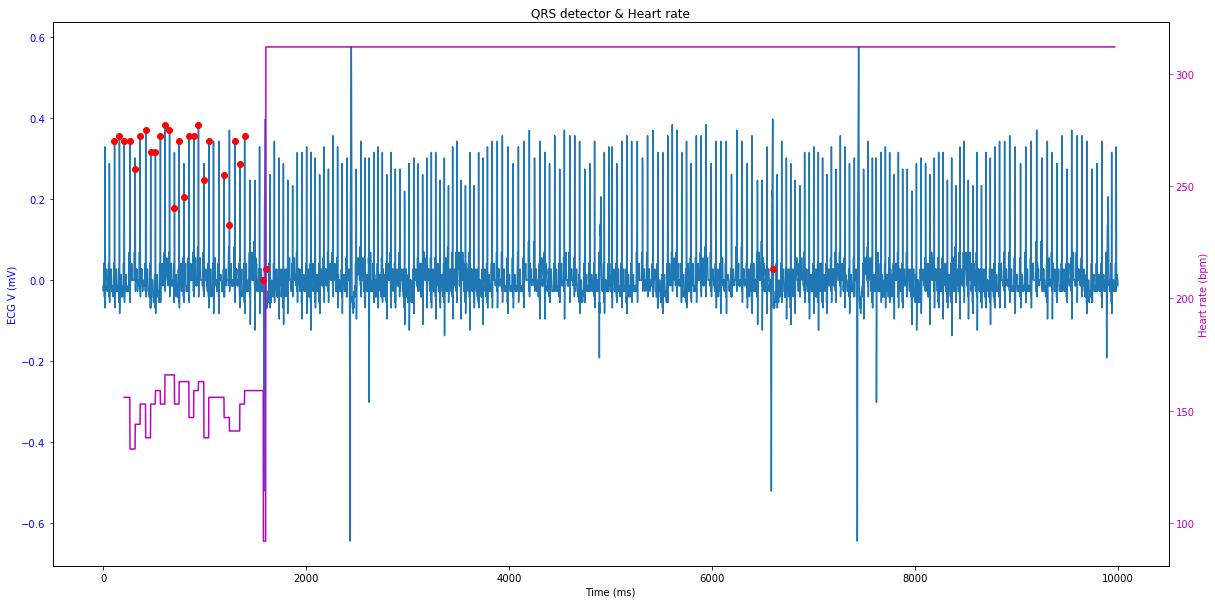

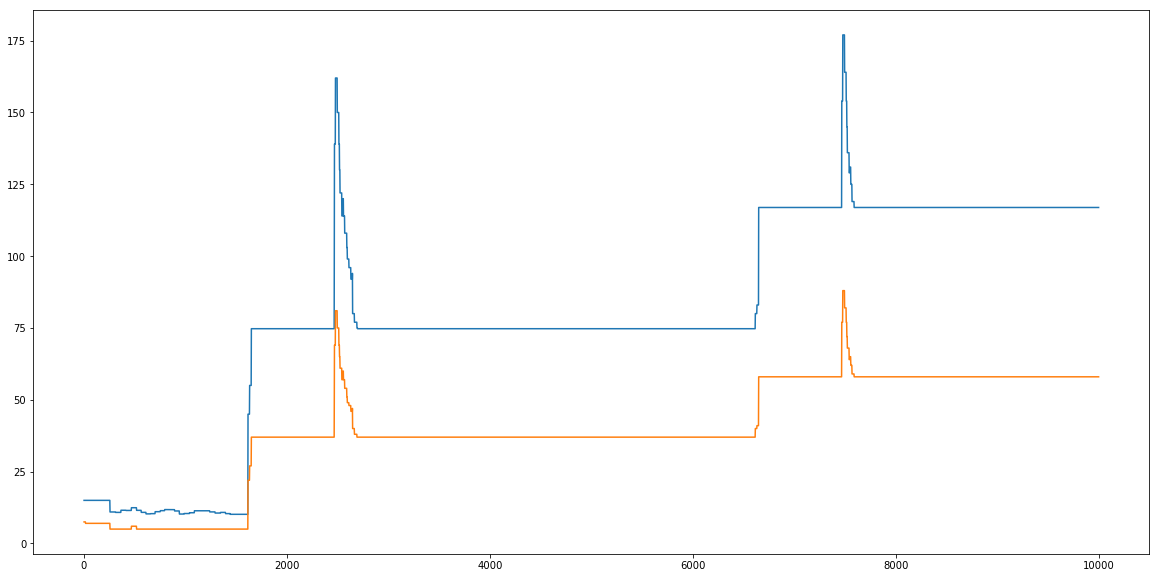

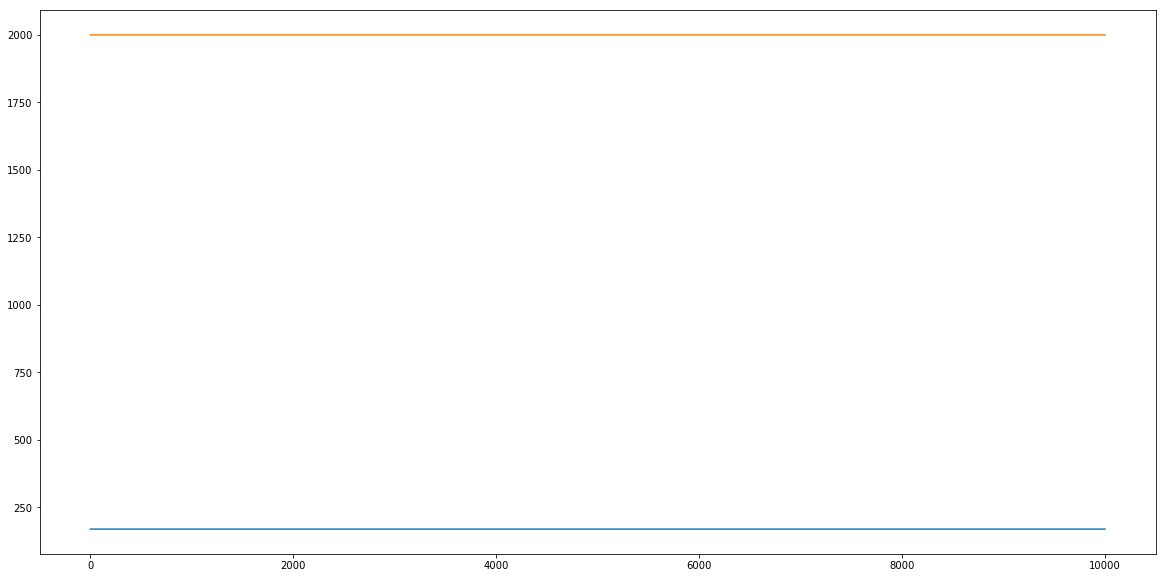

In [144]:
sig_name = "II"
idx_sig = fields['signame'].index(sig_name)

print('Index for signame {} is {}. It contains {} samples.'.format(sig_name, idx_sig, sig.shape[0]))
size = 10000#sig.shape[0]
fs = fields['fs']

sig1 = sig[None:None, idx_sig]

# data_gen = (RepeatPattern(sig1[:size])-0.5)/2.0
data_gen = RepeatPattern(sig1[:size])

# Band-pass filter
lp_gen = LowPass(data_gen) # Low-pass filter
hp_gen = HighPass(lp_gen) # High-pass filter

# Derivation
diff_gen = Differentiator(hp_gen)

# Squaring
sq_gen = diff_gen ** 2

# Moving Window Integration
mwi_width = 80 #ms
mwi_size = int((mwi_width/1000)*fs)
print('MWI size: {}'.format(mwi_size))
mwi_gen = MovingWindowIntegration(sq_gen, mwi_size)

# QRS detector
qrs_gen = QRS(mwi_gen, fs)

x_sig = range(size)
y_sig = []
x_rpeak = []
y_rpeak = []
x_hr = []
y_hr = []

t1s = []
t2s = []
rls = []
rhs = []
for k in range(size):
    v = data_gen.get_single()
    d, hr, t1, t2, rl, rh = qrs_gen.get_single()
    t1s.append(t1)
    t2s.append(t2)
    rls.append(rl)
    rhs.append(rh)
    y_sig.append(v)
    if not numpy.isnan(hr):
        x_hr.append(k-30)
        y_hr.append(int(hr))
    if d == 1:
#         print(y_sig[-30])
        y_rpeak.append(y_sig[-30])
        x_rpeak.append(k-30)

fig, ax_left = plt.subplots(figsize=(20, 10))
ax_right = ax_left.twinx()
ax_left.plot(x_sig, y_sig, label='Original signal')
ax_left.plot(x_rpeak, y_rpeak, 'ro', label='Rpeak')
ax_right.plot(x_hr, y_hr, label='Heart rate', color='m')

ax_left.set_title('QRS detector & Heart rate')

ax_left.set_xlabel('Time (ms)')
ax_left.set_ylabel('ECG V (mV)', color='b')
ax_right.set_ylabel('Heart rate (bpm)', color='m')
# Make the y-axis label, ticks and tick labels match the line color.
ax_left.tick_params('y', colors='b')
ax_right.tick_params('y', colors='m')


plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t1s)
ax.plot(t2s)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(rls)
ax.plot(rhs)
plt.show()